# Experiment 2: BOW/TFIDF

In [1]:
# Load for Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/home/elenaruiz/Documents/FNC')
import pandas as pd 
import numpy as np 
from src.utils import io
from sklearn.feature_extraction.text import TfidfTransformer
from src.fake_news_detector.core.encoders import tfidf as t

## 1. Import `dataset_raw.json`

In [2]:
articles = io.read_json_file('/home/elenaruiz/Documents/FNC/src/data/dataset_content.json')
df = pd.DataFrame(data=articles['articles']) # Put in pandas dataframe

In [3]:
# Get useful info from our dataset:
dataset = pd.DataFrame()
list_f = ['all_word', 'title_word', 'subtitle_word', 'negative_words','positive_words', 'adjective_words', 'common_noun_words', 'verb_words']
dataset = df[list_f]
dataset['label'] = df['fake']*1
dataset.head()

,all_word,title_word,subtitle_word,negative_words,positive_words,adjective_words,common_noun_words,verb_words,label
0,"[find, corpse, vegetarian, restaurant, Bangkok...","[find, corpse, vegetarian, restaurant, Bangkok]","[find, make, speculate, international, media, ...","[corpse, kill, fire, complain, deny, victim, v...",[like],"[vegetarian, make, speculate, international, h...","[corpse, restaurant, Bangkok, media, establish...","[find, serve, clarify, kill, collect, complain...",1
1,"[switzerland, warn, authorize, extradition, po...","[switzerland, warn, authorize, extradition, po...","[spokesman, Swiss, government, clarify, case, ...","[stress, offences, offences, accuse, argue, pe...","[Justice, like, Supreme, fair, perfectly]","[extradition, political, Swiss, priori, legal,...","[switzerland, warn, crimes, A, spokesman, gove...","[authorize, analyze, say, seem, link, A, add, ...",1
2,"[navarre, censor, Songs, Amaral, Shakira, song...","[navarre, censor, Songs, Amaral, Shakira, song...","[may, use, school]","[censor, violence, ban, bad, fight, shit]","[promote, great, hope, promote, like, affectio...","[navarre, educational, decide, several, great,...","[censor, Songs, Amaral, Shakira, song, Madman,...","[use, find, song, give, hope, promote, center,...",1
3,"[woman, pretend, blind, years, greet, people, ...","[woman, pretend, blind, years, greet, people]","[truth, discover]","[blind, blind, injury, blind, avoid]","[greet, truth, friends, truth, greet, justice]","[greet, discover, Spanish, social, avoid, many...","[woman, years, people, Carmen, Jiménez, family...","[pretend, truth, tell, tire, see, stand, say, ...",1
4,"[arrested, ejaculate, boss, coffee, last, four...","[arrested, ejaculate, boss, coffee, last, four...","[recognize, action, discussion]","[arrested, detain, arrest, prison, abuse]","[United, strong, superior, proud]","[ejaculate, last, unveil, despicable, strong, ...","[boss, coffee, years, action, discussion, Lewi...","[arrested, recognize, detain, ejaculate, bring...",1


## 2. Dictionary creation and word vectorization

In [4]:
def join_lists(dataset, word_lists):
    result = []
    for _, row in dataset.iterrows():
        text_join = ""
        for feature in word_lists:
            doc_list = row[feature]
            text_join += ' '.join(doc_list)
        result.append(text_join)
    return result  

In [5]:
dataset['all_joined'] = join_lists(dataset, ['all_word'])
dataset['all_joined'].head()

0    find corpse vegetarian restaurant Bangkok find...
1    switzerland warn authorize extradition politic...
2    navarre censor Songs Amaral Shakira song Madma...
3    woman pretend blind years greet people Now tru...
4    arrested ejaculate boss coffee last four years...
Name: all_joined, dtype: object

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=42)

### 2.1 TF-IDF for all text

In [7]:
# VARIABLES
X_train = df_train['all_joined'].values
Y_train = df_train['label'].values
X_test = df_test['all_joined'].values
Y_test = df_test['label'].values

In [8]:
# REAL
X_train_real = df_train.loc[df_train['label'] == 0]
X_train_real = X_train_real['all_joined']

X_train_fake = df_train.loc[df_train['label'] == 1]
X_train_fake = X_train_fake['all_joined']

cv = CountVectorizer()
X_train_counts = cv.fit_transform(dataset['all_joined'].values)
X_train_counts_real = cv.transform(X_train_real)
X_train_counts_fake = cv.transform(X_train_fake)
print(X_train_counts_fake.shape, X_train_counts_real.shape, X_train_counts.shape)

(57, 6713) (52, 6713) (137, 6713)


In [9]:
# FAKE
tf_transformer_real = TfidfTransformer(use_idf=True).fit(X_train_counts_real)
X_train_tf_real = tf_transformer_real.transform(X_train_counts_real)
X_train_tf_real.shape

(52, 6713)

In [10]:
# FAKE
tf_transformer_fake = TfidfTransformer(use_idf=True).fit(X_train_counts_fake)
X_train_tf_fake = tf_transformer_fake.transform(X_train_counts_fake)
X_train_tf_fake.shape


(57, 6713)

In [11]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results, feature_vals

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [12]:
sorted_items=sort_coo(X_train_tf_fake.tocoo())
feature_names =cv.get_feature_names()
results, top_fake_words = extract_topn_from_vector(feature_names, sorted_items, 600)
results

{'rice': 0.689,
 'cheese': 0.637,
 'dog': 0.624,
 'restaurant': 0.5,
 'ikea': 0.5,
 'switzerland': 0.481,
 'crocodiles': 0.48,
 'sexual': 0.458,
 'foreign': 0.442,
 'songs': 0.438,
 'cor': 0.435,
 'wax': 0.428,
 'guitar': 0.424,
 'day': 0.155,
 'water': 0.152,
 'beach': 0.41,
 'echenique': 0.41,
 'libya': 0.409,
 'semen': 0.405,
 'store': 0.4,
 'prisoners': 0.379,
 'alejandro': 0.395,
 'blind': 0.39,
 'museum': 0.385,
 'pastor': 0.384,
 'cold': 0.383,
 'women': 0.202,
 'drivers': 0.192,
 'use': 0.149,
 'military': 0.373,
 'crush': 0.371,
 'feminist': 0.37,
 'ugly': 0.368,
 'pp': 0.366,
 'guindos': 0.36,
 'melilla': 0.359,
 'police': 0.153,
 'forest': 0.355,
 'minimum': 0.354,
 'control': 0.206,
 'vallecas': 0.346,
 'office': 0.344,
 'abedi': 0.341,
 'children': 0.161,
 'feminism': 0.34,
 'cents': 0.337,
 'airline': 0.337,
 'muslim': 0.324,
 'que': 0.163,
 'wage': 0.322,
 'madrid': 0.14,
 'families': 0.321,
 'extradition': 0.321,
 'flag': 0.314,
 'vagina': 0.314,
 'parent': 0.314,
 'ger

In [13]:
sorted_items=sort_coo(X_train_tf_real.tocoo())
results, top_real_words = extract_topn_from_vector(feature_names, sorted_items, 600)

In [14]:
top_real_words_coded = cv.transform([' '.join(top_real_words)])
top_fake_words_coded = cv.transform([' '.join(top_fake_words)])
df_train['cv_value'] = cv.transform(df_train['all_joined'])


In [15]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def get_cosine_similarity(q1_csc, q2_csc):
    cosine_sim = []
    for i,j in zip(q1_csc, q2_csc):
        sim = cs(i,j)
        cosine_sim.append(sim[0][0])
    
    return cosine_sim
    

In [16]:
df_train['cos_fake'] = df_train['label']*0.000000000005
df_train['cos_real'] = df_train['label']*0.000000000005
for index, row in df_train.iterrows():
    to_number = cv.transform([row['all_joined']])
    cosine_sim_fake = get_cosine_similarity(top_fake_words_coded, to_number)
    cosine_sim_real = get_cosine_similarity(top_real_words_coded, to_number)
    df_train.at[index,'cos_fake'] = cosine_sim_fake[0]
    df_train.at[index,'cos_real'] = cosine_sim_real[0]

## 4. Classification

In [17]:
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from src.fake_news_detector.core.classificators import SupportVectorMachine as s
from src.fake_news_detector.core.classificators import helpers

In [18]:
def svc_param_selection(X, y, nfolds, kernel):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

### 3.1 TF-IDF all text

#### 3.1.1 Tranform test data

In [19]:
df_test['cos_fake'] = df_test['label']*0.000000000005
df_test['cos_real'] = df_test['label']*0.000000000005
for index, row in df_test.iterrows():
    to_number = cv.transform([row['all_joined']])
    cosine_sim_fake = get_cosine_similarity(top_fake_words_coded, to_number)
    cosine_sim_real = get_cosine_similarity(top_real_words_coded, to_number)
    df_test.at[index,'cos_fake'] = cosine_sim_fake[0]
    df_test.at[index,'cos_real'] = cosine_sim_real[0]
X_test_tf = df_test[['cos_real', 'cos_fake']].values

In [20]:
df_train[['cos_real', 'cos_fake']].head()

,cos_real,cos_fake
10,0.067576,0.154907
130,0.165752,0.147831
51,0.030970,0.108463
11,0.098160,0.142764
114,0.086762,0.141631


#### 3.1.2 Search best parameters for SVC models

In [21]:
X_train_tf = df_train[['cos_real', 'cos_fake']].values

rbf_values = svc_param_selection(X_train_tf, Y_train, 2, 'rbf')
linear_values = svc_param_selection(X_train_tf, Y_train, 2, 'linear')
poly_values = svc_param_selection(X_train_tf, Y_train, 2, 'poly')
sigmoid_values = svc_param_selection(X_train_tf, Y_train, 2, 'sigmoid')

/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [22]:
models = {}
models['rbf'] = svm.SVC(kernel='rbf', C= rbf_values['C'], gamma=rbf_values['gamma'])
models['linear']  = svm.SVC(kernel='linear', C= linear_values['C'], gamma=linear_values['gamma'])
models['poly']  = svm.SVC(kernel='poly',C=poly_values['C'], gamma=poly_values['gamma'])
models['sigmoid'] = svm.SVC(kernel='sigmoid', C=sigmoid_values['C'], gamma=sigmoid_values['gamma'])

In [23]:
scores = s.run_models(models, X_train_tf, Y_train, X_test_tf, Y_test)
for model in scores:
    print('For model', model)
    print('Training score: {}. Test score: {}'.format(scores[model]['train'],scores[model]['test']))

For model rbf
Training score: 0.981651376146789. Test score: 0.75
For model linear
Training score: 0.981651376146789. Test score: 0.75
For model poly
Training score: 0.5229357798165137. Test score: 0.4642857142857143
For model sigmoid
Training score: 0.981651376146789. Test score: 0.75


In [24]:
import matplotlib.pyplot as plt
from  matplotlib.colors import ListedColormap
X_set, y_set = X_train_tf, Y_train

aranged_pc1 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
aranged_pc2 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

X1, X2 = np.meshgrid(aranged_pc1, aranged_pc2)
plt.contourf(X1, X2, models['rbf'].predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
alpha = 0.5, cmap = ListedColormap(('orange', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM prediction from LDA transformation')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<Figure size 640x480 with 1 Axes>

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


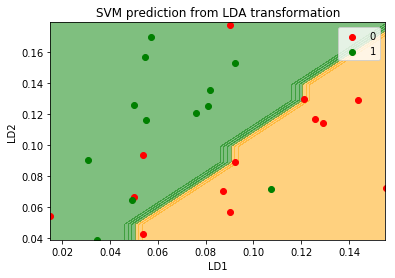

In [25]:
import matplotlib.pyplot as plt
from  matplotlib.colors import ListedColormap
X_set, y_set = X_test_tf, Y_test

aranged_pc1 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
aranged_pc2 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

X1, X2 = np.meshgrid(aranged_pc1, aranged_pc2)
plt.contourf(X1, X2, models['rbf'].predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
alpha = 0.5, cmap = ListedColormap(('orange', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM prediction from LDA transformation')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

TODO: Buscar top palabras optimas